In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

In [6]:
idxc = pd.read_csv("../task3/clean_data/clean_idxc.csv")
y_true = pd.read_csv("../task3/clean_data/clean_true.csv")

In [7]:
# 计算交易折扣因子
def get_mu(df,c1,c2):
    
    def relu(x):
        if x>=0:
            return x
        else:
            return 0
    
    def function_mu(df,c1,c2,mu):
        sigma = 0
        for i in range(1,len(df)):
            sigma+=relu(df['wt_prime'].iloc[i]-mu*df['w_t'].iloc[i])
        numerator = 1+c1-c1*df['wt_prime'].iloc[0]-(2*c1+c2)*sigma
        denominator = 1+c1-c1*df['w_t'].iloc[0]
        return numerator/denominator

    
    mu_list=[]
    eps = 1e-15
    delta = 1
    mu = 1
    mu_list.append(mu)
    while delta>eps:
        mu = function_mu(df,c1,c2,mu)
        mu_list.append(mu)
        delta = abs(mu_list[-1]-mu_list[-2])
    
    return mu

In [8]:
# c1为因滑点和佣金带来的损失率(买入或卖出)，c2为税金率(仅卖出)
c1 = 0.0012+0.00015
c2 = 0.001

In [9]:
# 检查是否要删除某些trade_date(个股数据在idxc却不在y_true中)
date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
code_idx = np.sort(np.array(list(set(y_true['stock_code']))))
delete_date = []
for date in date_idx:
    ret_code = set(y_true[y_true['trade_date']==date]['stock_code'])
    idxc_code = set(idxc[idxc['trade_date']==date]['stock_code'])
    if len(idxc_code-ret_code)>0:
        delete_date.append([date,idxc_code-ret_code])
print(delete_date)

[]


In [10]:
y_true['stock_return']+=1
y_true = y_true.rename(columns={'stock_return':'y_t'})

In [11]:
# 设原始资产价值为1
pt=1
pt_list,mu_list=[],[]
pt_list.append(pt)
# 从第二天开始产生资产价值时间序列{pt},交易折扣因子序列{mu}
date_idx = date_idx[1:]
for date in date_idx:
    date_yt = y_true[y_true['trade_date']==date].set_index('stock_code')['y_t']
    last_date_w = idxc[idxc['trade_date']==date-1].set_index('stock_code')['weight']
    last_date_w = last_date_w.rename("w_t-1")
    date_w = idxc[idxc['trade_date']==date].set_index('stock_code')['weight']
    date_w = date_w.rename('w_t')
    df = pd.concat([date_yt,last_date_w,date_w],axis=1,join='outer')
    df = df.fillna(0)
    cash = pd.DataFrame({'stock_code':[-1],'y_t':[1],'w_t-1':[1-df['w_t-1'].sum()],'w_t':[1-df['w_t'].sum()]})
    cash = cash.set_index('stock_code')
    df = pd.concat([cash,df],axis=0)
    df['wt_prime']=(df['y_t']*df['w_t-1'])/((df['y_t']*df['w_t-1']).sum())
    pt_prime = pt*((df['y_t']*df['w_t-1']).sum())
    mu = get_mu(df,c1,c2)
    pt = pt_prime*mu
    mu_list.append(mu)
    pt_list.append(pt)

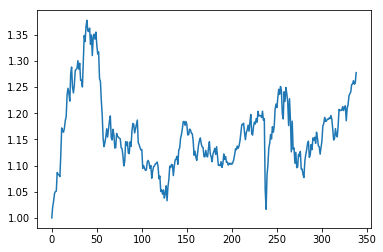

In [50]:
plt.plot(np.array(pt_list))
plt.show()

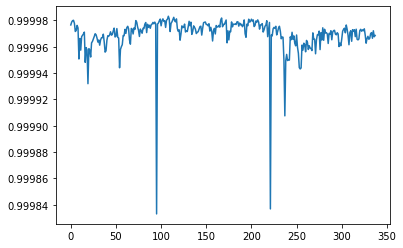

In [12]:
plt.plot(np.array(mu_list))
plt.show()